# 04c - Extended Covariate Cox Models for Pre-ICU RAAS Exposure in ICU COPD Patients

---

## 0. Overview
This analysis refines the mortality modeling of pre-ICU RAAS exposure among COPD ICU patients by incorporating additional comorbidities and severity measures. Following the same analytical framework as Sections [04a](04a_outcomes_and_modeling.ipynb) and [04b](04b_outcomes_and_modeling_raas_subgroups.ipynb), this section evaluates whether the protective association observed earlier remains robust after extended adjustment. Two Cox proportional hazards models were constructed: (1) a core covariate model and (2) a sensitivity model additionally adjusting for ICU type. Model diagnostics including Schoenfeld residual tests were performed to examine proportional hazards assumptions.

---

## 1. Introduction
Pre-ICU RAAS exposure (ACE inhibitors and ARBs) is common among patients with chronic cardiopulmonary conditions. In critically ill COPD patients, RAAS pathway modulation may provide benefits through cardiovascular stabilization, anti-inflammatory effects, and modulation of airway remodeling pathways. Earlier analyses ([04a](04a_outcomes_and_modeling.ipynb) and [04b](04b_outcomes_and_modeling_raas_subgroups.ipynb)) indicated a potential protective association between pre-ICU RAAS exposure and in-hospital mortality.

However, pre-ICU RAAS exposure is also tightly linked to underlying comorbidities such as congestive heart failure (CHF), chronic kidney disease (CKD), and diabetes—each of which independently influences mortality risk. This section extends prior models by incorporating these covariates along with baseline severity and demographic factors. A further sensitivity analysis adjusts for ICU type to evaluate whether institutional or workflow differences modify or confound the pre-ICU RAAS exposure–mortality relationship.

---

## 2. Methods
### 2.1 Data Sources and Analysis Inputs

- This analysis uses MIMIC-IV v3.1 hosted on BigQuery and builds on the upstream cohort and exposure construction pipeline (01–03).
- Time-to-death outcomes for in-hospital mortality are obtained from `copd_raas.cohort_copd_outcomes` created in Analysis [04a](04a_outcomes_and_modeling.ipynb) via [04_build_outcomes.sql](../sql/04_build_outcomes.sql).
- pre-ICU RAAS exposure subclass–specific variables are obtained from `copd_raas.cohort_copd_raas_detailed` created in Analysis [02](02_cohort_and_exposures.ipynb) via [02_exposure_raas_detailed.sql](../sql/02_exposure_raas_detailed.sql).
- For Analysis 04c, ACE inhibitor (ACEi) and angiotensin receptor blocker (ARB) exposure flags are merged with the outcome table at the ICU-stay level using the composite key (`subject_id`, `hadm_id`, `stay_id`).

This structure ensures consistent cohort definition and outcome ascertainment
across Analyses [04a](04a_outcomes_and_modeling.ipynb) and [04b](04b_outcomes_and_modeling_raas_subgroups.ipynb), while enabling subclass-specific exposure modeling.

### 2.2 Study Cohort
The study cohort is derived from `cohort_copd_outcomes_extended`, representing 11,964 ICU admissions for COPD patients in MIMIC-IV v3.1. ICU stay information, demographics, comorbidities, pre-ICU RAAS exposure, and hospital outcomes were included.

### 2.3 Exposure

### 2.4 Outcomes
The primary endpoint was **in-hospital mortality**. Time-to-death was calculated as days from ICU admission to death or discharge (censoring).　

In-hospital death was defined using admissions.hospital_expire_flag. Time-to-death was calculated as days from ICU admission (intime) to hospital dischtime, which corresponds to discharge or in-hospital death in MIMIC-IV.

### 2.5 Covariates

Covariates were selected based on clinical relevance and their potential role as confounders of the association between pre-ICU RAAS exposure and in-hospital mortality:

* **Demographics:** age, male sex
* **Baseline illness severity:** first-day SOFA score (first 24 hours of ICU stay)
* **Major comorbidities:** congestive heart failure (CHF), chronic kidney disease (CKD), diabetes
* **ICU type:** included only in sensitivity analyses

**Conceptual framework:**
Age, sex, and chronic comorbidities (CHF, CKD, diabetes) were treated as baseline confounders, as they are associated with both pre-ICU RAAS exposure and mortality risk.

SOFA score was included as a marker of **baseline acute illness severity at ICU admission**, rather than as an intermediate outcome. Although SOFA is strongly prognostic for mortality, it was measured at ICU entry (prior to outcome occurrence) and was used to control for confounding by acute severity at presentation.

CHF was modeled as a **pre-existing chronic comorbidity** rather than an outcome, based on diagnosis codes recorded prior to ICU admission. While CHF contributes to mortality risk, it precedes both exposure and outcome in the causal timeline and therefore functions as a confounder rather than a mediator.

ICU type was added in sensitivity analyses to evaluate robustness of results to differences in case-mix and care context across ICU settings.

### 2.6 Statistical Analysis

Cox proportional hazards regression models were fitted using the *lifelines* library to evaluate the association between pre-ICU RAAS exposure and in-hospital mortality among ICU-admitted patients with COPD. Time-to-death was defined as days from ICU admission to in-hospital death, with discharge treated as censoring.

Two multivariable models were prespecified. All primary analyses used an unpenalized Cox model (penalizer = 0.0) to preserve interpretability of hazard ratio estimates.

**Core model**

The core model was adjusted for baseline covariates described in Section 2.5, including age, sex, first-day SOFA score, CHF, CKD, and diabetes mellitus.

CHF, CKD, and diabetes were treated as *pre-existing chronic comorbidities* defined using diagnosis codes recorded prior to ICU admission. These variables were included as baseline confounders because they are associated with both pre-ICU RAAS exposure prescribing and mortality risk, and temporally precede both exposure and outcome.

Although SOFA score is strongly prognostic for mortality, it was measured at ICU admission (prior to outcome occurrence) and was included to control for baseline acute illness severity at presentation, rather than as an intermediate outcome.

Baseline hazards were stratified by calendar time using `anchor_year_group` to allow the underlying hazard to vary across different calendar periods, accounting for temporal changes in ICU practice and mortality risk.

**Sensitivity analysis**

A sensitivity model additionally adjusted for ICU type to evaluate robustness of results to differences in case-mix and care context across ICU settings.

**Model diagnostics**

The proportional hazards assumption was evaluated using Schoenfeld residuals. No major violations were identified. Hazard ratios (HRs) with 95% confidence intervals (CIs) were reported, and statistical significance was assessed using two-sided tests with a significance level of 0.05.


## 3. Data Preparation
### 3.1 Load Data

In [14]:
# Use Application Default Credentials (my user account)
# This account already has PhysioNet BigQuery access.

from google.cloud import bigquery
from google.auth import default
from pathlib import Path
import pandas as pd

# 1. Define project ID
PROJECT_ID = "mimic-iv-portfolio"

# 2. Get ADC credentials
creds, adc_project = default()

# 3. Initialize BigQuery client
client = bigquery.Client(project=PROJECT_ID, credentials=creds)

print("Connected to BigQuery project:", PROJECT_ID)
print("ADC default project:", adc_project)

# 4. Helper to run a SQL script file (DDL, CREATE TABLE, etc.)
def run_sql_script(path) :
    """
    Read a .sql file from disk, execute it in BigQuery,
    and wait until the job finishes.
    Use this for CREATE TABLE / INSERT INTO scripts.
    """
    sql_path = Path(path)
    with sql_path.open("r") as f:
        query = f.read()
    job = client.query(query)
    job.result()
    print(f"Executed SQL script: {sql_path.name}")

# 5. Helper for SELECT queries → DataFrame
def query_to_df(query) :
    """
    Run a SELECT query in BigQuery and return a pandas DataFrame.
    """
    job = client.query(query)
    return job.to_dataframe(create_bqstorage_client=False)


Connected to BigQuery project: mimic-iv-portfolio
ADC default project: mimic-iv-portfolio


In [15]:

# Build extended outcome/feature table

run_sql_script("../sql/04_build_outcomes_extended.sql")
print("Created/updated table: mimic-iv-portfolio.copd_raas.cohort_copd_outcomes_extended")


Executed SQL script: 04_build_outcomes_extended.sql
Created/updated table: mimic-iv-portfolio.copd_raas.cohort_copd_outcomes_extended


In [16]:
# Load extended-like data directly from cohort_copd_outcomes

sql_load = """
SELECT
  *
FROM `mimic-iv-portfolio.copd_raas.cohort_copd_outcomes_extended`
"""

df_ext = query_to_df(sql_load)
print("Loaded cohort for 04c (from cohort_copd_outcomes_extended):", df_ext.shape)
df_ext.info()

Loaded cohort for 04c (from cohort_copd_outcomes_extended): (11964, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11964 entries, 0 to 11963
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   subject_id                  11964 non-null  Int64         
 1   hadm_id                     11964 non-null  Int64         
 2   stay_id                     11964 non-null  Int64         
 3   intime                      11964 non-null  datetime64[us]
 4   outtime                     11962 non-null  datetime64[us]
 5   icu_los                     11962 non-null  float64       
 6   age                         11964 non-null  Int64         
 7   gender                      11964 non-null  object        
 8   anchor_year                 11964 non-null  Int64         
 9   anchor_year_group           11964 non-null  object        
 10  hosp_los                    11964 non-null  fl

### 3.2 Preprocessing: gender and `icu_type` indicator

In [17]:
# Copy data for modeling
cox_df_04c = df_ext.copy()

# One-hot encode gender and ICU type
# We drop the first category to avoid dummy variable trap
cox_df_04c = pd.get_dummies(
    cox_df_04c,
    columns=["gender", "icu_type"],
    drop_first=True,
)

# Preview the columns created
cox_df_04c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11964 entries, 0 to 11963
Data columns (total 37 columns):
 #   Column                                                     Non-Null Count  Dtype         
---  ------                                                     --------------  -----         
 0   subject_id                                                 11964 non-null  Int64         
 1   hadm_id                                                    11964 non-null  Int64         
 2   stay_id                                                    11964 non-null  Int64         
 3   intime                                                     11964 non-null  datetime64[us]
 4   outtime                                                    11962 non-null  datetime64[us]
 5   icu_los                                                    11962 non-null  float64       
 6   age                                                        11964 non-null  Int64         
 7   anchor_year                    

---

## 4. Results

In [18]:
# ============================================================
# 1) Fit Cox models (core model & ICU-extended model)
# ============================================================

from lifelines import CoxPHFitter
import pandas as pd

# Core covariates only
core_covariates_04c = [
    "raas_pre_icu",
    "age",
    "gender_M",
    "sofa_score",
    "chf",
    "ckd",
    "diabetes",
]

# ICU type covariates（one-hot encoded columns）
icu_covariates_04c = [c for c in cox_df_04c.columns if c.startswith("icu_type_")]

# Extended covariates = core + ICU type
extended_covariates_04c = core_covariates_04c + icu_covariates_04c

# ============================================================
# 2) Extract HR tables (with formatted p-values)
# ============================================================

def extract_hr_table(model, digits_hr=3, format_p=True):
    """
    Extract a tidy HR table from a lifelines CoxPHFitter object.

    Parameters
    ----------
    model : CoxPHFitter
        Fitted Cox model.
    digits_hr : int
        Number of decimal places for HR and CI.
    format_p : bool
        If True, add a formatted 'p' column (e.g., '<0.001', '0.017').

    Returns
    -------
    DataFrame with columns:
        HR, HR_lower_95, HR_upper_95, p_value (+ optionally p)
    """
    summ = model.summary

    out = pd.DataFrame(
        {
            "HR": summ["exp(coef)"],
            "HR_lower_95": summ["exp(coef) lower 95%"],
            "HR_upper_95": summ["exp(coef) upper 95%"],
            "p_value": summ["p"],
        }
    )

    # Round numerical HR and CI values for cleaner presentation
    if digits_hr is not None:
        out[["HR", "HR_lower_95", "HR_upper_95"]] = (
            out[["HR", "HR_lower_95", "HR_upper_95"]].round(digits_hr)
        )

    # Create a formatted p-value column (as string)
    if format_p:
        def format_p(x):
            if x < 0.001:
                return "<0.001"
            else:
                return f"{x:.3f}"   # Example output: 0.017, 0.481, <0.001

        out["p"] = out["p_value"].apply(format_p)

    return out

### 4.1 Main Cox Model (Core Covariates)(penalizer=0.0)

In [19]:
# ----------------------------
# Fit core model (penalizer=0.0)
# ----------------------------
cols_core = ["time_to_event_days", "death_event", "anchor_year_group"] + core_covariates_04c

df_fit_core = cox_df_04c[cols_core].dropna().copy()

cph_04c_core = CoxPHFitter(penalizer=0.0)
cph_04c_core.fit(
    df_fit_core,
    duration_col="time_to_event_days",
    event_col="death_event",
    strata=["anchor_year_group"],
)


# Main Cox Model - Core model
hr_core = extract_hr_table(cph_04c_core, digits_hr=3, format_p=True)
print("=== Core model: Adjusted hazard ratios ===")
display(hr_core[["HR", "HR_lower_95", "HR_upper_95", "p"]])

=== Core model: Adjusted hazard ratios ===


,HR,HR_lower_95,HR_upper_95,p
covariate,,,,
raas_pre_icu,0.806,0.652,0.997,0.047
age,1.039,1.035,1.044,<0.001
gender_M,0.921,0.836,1.015,0.095
sofa_score,1.206,1.191,1.220,<0.001
chf,0.981,0.886,1.086,0.709
ckd,0.919,0.825,1.024,0.127
diabetes,0.927,0.834,1.030,0.156


### 4.2 Main Cox Model (Core Covariates)(penalizer=0.1)

In [20]:
# ----------------------------
# Fit core model (penalizer=0.1)
# ----------------------------
cols_core = ["time_to_event_days", "death_event", "anchor_year_group"] + core_covariates_04c

df_fit_core= cox_df_04c[cols_core].dropna().copy()

cph_04c_core_001 = CoxPHFitter(penalizer=0.1)
cph_04c_core_001.fit(
    df_fit_core,
    duration_col="time_to_event_days",
    event_col="death_event",
    strata=["anchor_year_group"],
)


# Main Cox Model - Core model
hr_core_001 = extract_hr_table(cph_04c_core_001, digits_hr=3, format_p=True)
print("=== Core model: Adjusted hazard ratios ===")
display(hr_core_001[["HR", "HR_lower_95", "HR_upper_95", "p"]])

=== Core model: Adjusted hazard ratios ===


,HR,HR_lower_95,HR_upper_95,p
covariate,,,,
raas_pre_icu,0.877,0.759,1.014,0.077
age,1.020,1.016,1.023,<0.001
gender_M,0.969,0.900,1.043,0.402
sofa_score,1.129,1.117,1.140,<0.001
chf,1.016,0.943,1.096,0.669
ckd,1.019,0.939,1.104,0.657
diabetes,0.936,0.865,1.012,0.097


**Key Results (Core and Sensitivity Analyses)**

- Pre-ICU RAAS exposure showed a protective association with in-hospital mortality in the unpenalized core Cox model (HR = 0.81, 95% CI 0.65–1.00, p = 0.047).

- In a sensitivity analysis applying L2 penalization (penalizer = 0.1) to improve numerical stability, the association was attenuated and did not reach statistical significance, although the direction of effect remained protective (HR = 0.88, 95% CI 0.76–1.01, p = 0.077).

- Baseline severity, as measured by the SOFA score, was strongly and consistently associated with increased mortality across all model (HR approximately 1.13–1.21 per point increase, p < 0.001).

- Age showed a robust positive association with mortality in all models (p < 0.001).

- Other covariates, including sex, congestive heart failure, chronic kidney disease, and diabetes, were not independently associated with in-hospital mortality after multivariable adjustment.

Overall, the direction of effect consistently favored pre-ICU RAAS exposure, suggesting a potentially protective association; however, the sensitivity of the effect size to model penalization indicates residual confounding or collinearity with severity-related covariates.

### 4.3 Sensitivity Model Including ICU Type (penalizer=0.0)

In [21]:
# ----------------------------
# Fit ICU-extended model (penalizer=0.0)
# ----------------------------
cols_icu = ["time_to_event_days", "death_event", "anchor_year_group"] + extended_covariates_04c

df_fit_icu = cox_df_04c[cols_icu].dropna().copy()

cph_04c_icu = CoxPHFitter(penalizer=0.0)
cph_04c_icu.fit(
    df_fit_icu,
    duration_col="time_to_event_days",
    event_col="death_event",
    strata=["anchor_year_group"],
)

# Sensitivity Model Including ICU Type
hr_icu  = extract_hr_table(cph_04c_icu,  digits_hr=3, format_p=True)

print("\n=== Sensitivity model: Adjusted hazard ratios (with ICU type) ===")
display(hr_icu[["HR", "HR_lower_95", "HR_upper_95", "p"]])


=== Sensitivity model: Adjusted hazard ratios (with ICU type) ===


,HR,HR_lower_95,HR_upper_95,p
covariate,,,,
raas_pre_icu,0.938,0.756,1.163,0.559
age,1.041,1.036,1.045,<0.001
gender_M,0.930,0.844,1.025,0.146
sofa_score,1.204,1.189,1.219,<0.001
chf,0.893,0.803,0.992,0.035
ckd,0.901,0.808,1.005,0.062
diabetes,0.914,0.822,1.016,0.096
icu_type_Coronary Care Unit (CCU),3.250,2.585,4.085,<0.001
icu_type_Intensive Care Unit (ICU),11.834,4.318,32.433,<0.001


### 4.4 Sensitivity Model Including ICU Type (penalizer=0.1)

In [22]:
# ----------------------------
# Fit ICU-extended model (penalizer=0.01)
# ----------------------------
cols_icu = ["time_to_event_days", "death_event", "anchor_year_group"] + extended_covariates_04c

df_fit_icu = cox_df_04c[cols_icu].dropna().copy()

cph_04c_icu_001 = CoxPHFitter(penalizer=0.01)
cph_04c_icu_001.fit(
    df_fit_icu,
    duration_col="time_to_event_days",
    event_col="death_event",
    strata=["anchor_year_group"],
)

# Sensitivity Model Including ICU Type
hr_icu_001  = extract_hr_table(cph_04c_icu_001,  digits_hr=3, format_p=True)

print("\n=== Sensitivity model: Adjusted hazard ratios (with ICU type) ===")
display(hr_icu_001[["HR", "HR_lower_95", "HR_upper_95", "p"]])


=== Sensitivity model: Adjusted hazard ratios (with ICU type) ===


,HR,HR_lower_95,HR_upper_95,p
covariate,,,,
raas_pre_icu,0.892,0.728,1.093,0.270
age,1.037,1.032,1.041,<0.001
gender_M,0.934,0.850,1.026,0.153
sofa_score,1.192,1.178,1.206,<0.001
chf,0.913,0.826,1.010,0.077
ckd,0.923,0.831,1.024,0.131
diabetes,0.912,0.824,1.009,0.074
icu_type_Coronary Care Unit (CCU),2.197,1.848,2.612,<0.001
icu_type_Intensive Care Unit (ICU),8.312,3.050,22.656,<0.001


**Key Results (ICU-Extended Cox Models)**

- After additional adjustment for ICU type, pre-ICU RAAS exposure was not independently associated with in-hospital mortality.
  The estimated hazard ratio remained below 1, but confidence intervals were wide and crossed the null across penalization settings
  * penalizer = 0.0: HR = 0.94, 95% CI 0.76–1.16, p = 0.56
  * penalizer = 0.01: HR = 0.89, 95% CI 0.73–1.09, p = 0.27

- Baseline illness severity, as measured by the SOFA score, showed a strong and consistent association with mortality across all model(HR ≈ 1.19–1.20 per point increase, p < 0.001).

- ICU type was a major determinant of mortality risk, with several ICU categories demonstrating substantially higher hazards compared with the reference ICU, indicating strong institutional or case-mix effects.

- Age remained independently associated with increased mortality in all models (p < 0.001).

- Other comorbidities (CHF, CKD, diabetes) showed weak or borderline associations after full adjustment and were sensitive to penalization.

Overall, the protective association observed in earlier models was attenuated after accounting for ICU type, suggesting that the initial RAAS signal may be partially explained by differences in illness severity or ICU-level case mix rather than a direct causal effect.

### 4.5 Forest Plots

Forest plots were used to visualize adjusted hazard ratios (HRs) and 95% confidence
intervals (CIs) from the Cox proportional hazards models. All models shown here were
fitted without penalization (penalizer = 0.0).

- Figure 1 displays results from the core model adjusting for pre-ICU RAAS exposure, age, sex, SOFA score, and major comorbidities, with baseline hazards stratified
  by anchor_year_group.

- Figure 2 displays a sensitivity model additionally adjusting for ICU type indicators.


In both figures, points represent adjusted HRs and horizontal lines indicate
95% CIs, with the dashed vertical line at HR = 1.0 denoting the null association.

In [23]:
# Forest Plots
import matplotlib.pyplot as plt
def plot_forest(hr_df, title, focus_vars=None, figure_number=None, caption=None):
    """
    Plot a forest plot of hazard ratios with 95% CI,
    including Figure number and optional caption.
    """

    # Select covariates
    if focus_vars is not None:
        df = hr_df.loc[focus_vars].copy()
    else:
        df = hr_df.copy()

    # Sort for nicer visualization
    df = df.sort_values("HR")
    y_pos = range(len(df))

    # Create plot
    fig, ax = plt.subplots(figsize=(7, 0.5 * len(df)))

    ax.errorbar(
        df["HR"],
        list(y_pos),
        xerr=[df["HR"] - df["HR_lower_95"], df["HR_upper_95"] - df["HR"]],
        fmt="o",
        capsize=3,
    )

    # HR = 1 reference line
    ax.axvline(1.0, linestyle="--", color="gray")

    # Y-axis labels
    ax.set_yticks(list(y_pos))
    ax.set_yticklabels(df.index)

    ax.set_xlabel("Hazard Ratio (HR)")

    # Figure title
    if figure_number is not None:
        fig.suptitle(
            f"Figure {figure_number}. {title}",
            fontsize=14,
            fontweight="bold",
            y=1.03,
        )
    else:
        fig.suptitle(
            title,
            fontsize=14,
            fontweight="bold",
            y=1.03,
        )

    # Caption (THIS MUST BE INSIDE THE FUNCTION)
    if caption is not None:
        fig.text(
            0.01,
            -0.05,
            caption,
            ha="left",
            va="top",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

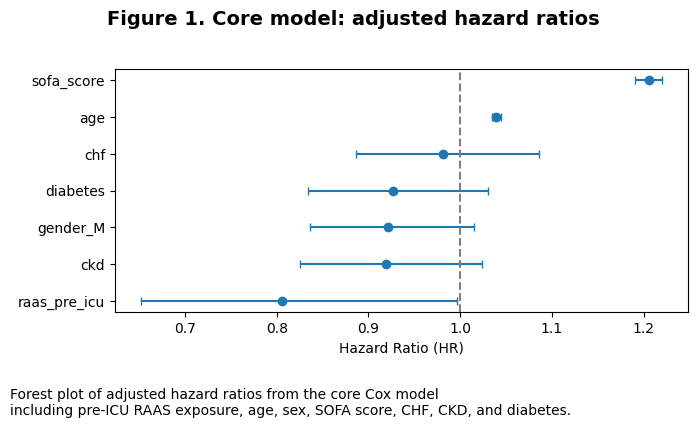

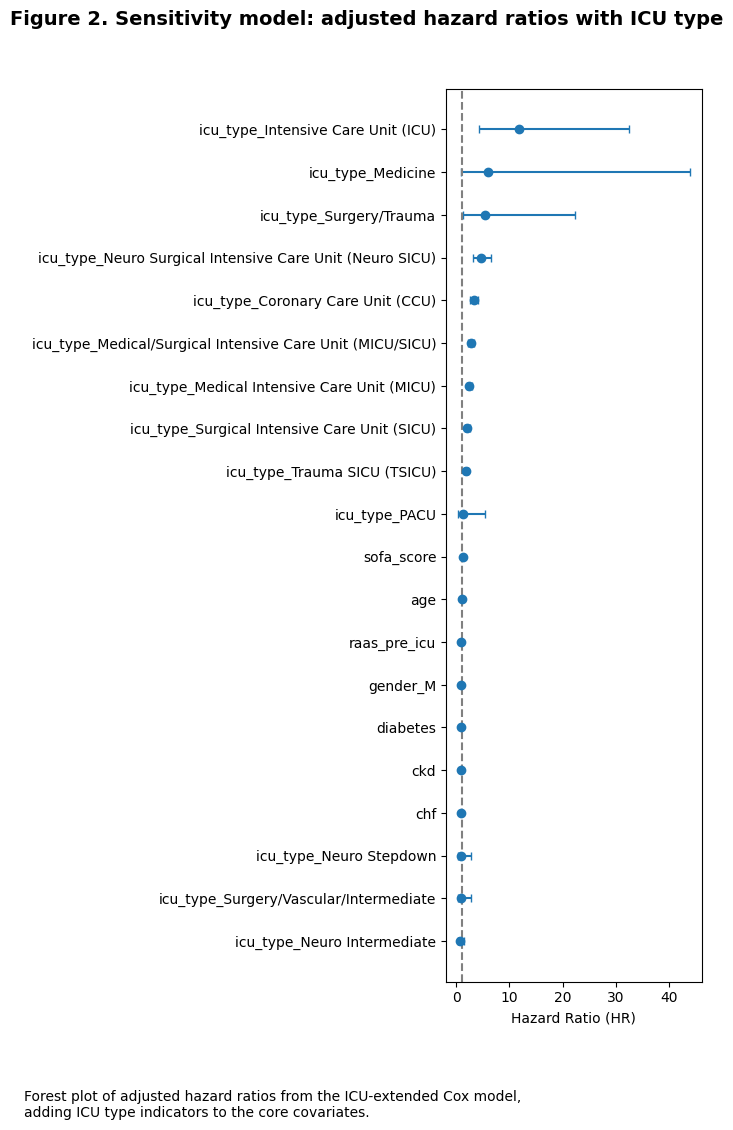

In [24]:
hr_core = extract_hr_table(cph_04c_core)
hr_icu  = extract_hr_table(cph_04c_icu)

# Figure 1: Core model
plot_forest(
    hr_core,
    title="Core model: adjusted hazard ratios",
    focus_vars=core_covariates_04c,
    figure_number=1,
    caption=(
        "Forest plot of adjusted hazard ratios from the core Cox model\n"
        "including pre-ICU RAAS exposure, age, sex, SOFA score, CHF, CKD, and diabetes."
    ),
)

# Figure 2: ICU-extended model
plot_forest(
    hr_icu,
    title="Sensitivity model: adjusted hazard ratios with ICU type",
    focus_vars=extended_covariates_04c,
    figure_number=2,
    caption=(
        "Forest plot of adjusted hazard ratios from the ICU-extended Cox model,\n" "adding ICU type indicators to the core covariates."
    ),
)

**Key Findings from Forest plots:**  

The core model highlights strong associations for age and SOFA score, while the
ICU-extended model demonstrates substantial heterogeneity across ICU types and
attenuation of the pre-ICU RAAS exposure effect toward the null.

### 4.6 Proportional Hazards Assessment

The proportional hazards (PH) assumption was evaluated for both the core model and the ICU-extended model using Schoenfeld residual–based tests. Specifically proportional_hazard_test with a rank-based time transformation was applied to each fitted Cox model.

In [25]:
# ============================================================
# PH test for core model
# ============================================================
from lifelines.statistics import proportional_hazard_test

core_cols_for_ph = (
    ["time_to_event_days", "death_event", "anchor_year_group"]
    + core_covariates_04c
)

# Create dataframe for PH test
df_core_ph = cox_df_04c[core_cols_for_ph].dropna().copy()

# Ensure all covariates are numeric (except strata)
num_cols = [c for c in df_core_ph.columns if c != "anchor_year_group"]
for col in num_cols:
    df_core_ph[col] = pd.to_numeric(df_core_ph[col], errors="coerce")

df_core_ph = df_core_ph.dropna().copy()

results_ph_core = proportional_hazard_test(
    cph_04c_core,
    df_core_ph,
    time_transform="rank",
)

print("=== Schoenfeld PH Test (core model) ===")
results_ph_core.summary

=== Schoenfeld PH Test (core model) ===


,test_statistic,p,-log2(p)
age,0.000635,0.979890,0.029309
chf,17.937375,0.000023,15.418750
ckd,0.005182,0.942613,0.085263
diabetes,0.916156,0.338486,1.562831
gender_M,0.149747,0.698777,0.517095
raas_pre_icu,0.037640,0.846168,0.240984
sofa_score,5.131800,0.023491,5.411727


In [26]:
# ============================================================
# PH test for ICU-extended model (self-contained)
# ============================================================

from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
import pandas as pd

# 1) Columns used in ICU-extended model
icu_cols_for_ph = (
    ["time_to_event_days", "death_event", "anchor_year_group"]
    + extended_covariates_04c
)

# 2) Build PH-test dataframe
df_icu_ph = cox_df_04c[icu_cols_for_ph].dropna().copy()

# Ensure covariates are numeric (except strata)
num_cols_icu = [c for c in df_icu_ph.columns if c != "anchor_year_group"]
for col in num_cols_icu:
    df_icu_ph[col] = pd.to_numeric(df_icu_ph[col], errors="coerce")

df_icu_ph = df_icu_ph.dropna().copy()

# 3) Fit ICU-extended Cox model (match your main setting here)
# NOTE: set penalizer=0.0 if your main 04c results/forest plots are penalizer=0.0
cph_04c_icu = CoxPHFitter(penalizer=0.0)
cph_04c_icu.fit(
    df_icu_ph,
    duration_col="time_to_event_days",
    event_col="death_event",
    strata=["anchor_year_group"],
)

# 4) Schoenfeld-based PH test
results_ph_icu = proportional_hazard_test(
    cph_04c_icu,
    df_icu_ph,
    time_transform="rank",
)

print("=== Schoenfeld PH Test (ICU-extended model) ===")
results_ph_icu.summary.sort_values("p")

=== Schoenfeld PH Test (ICU-extended model) ===


,test_statistic,p,-log2(p)
chf,1.269312e+01,0.000367,11.411921
sofa_score,9.201704e+00,0.002418,8.692030
icu_type_Surgery/Vascular/Intermediate,5.079152e+00,0.024215,5.367943
icu_type_Surgical Intensive Care Unit (SICU),2.310370e+00,0.128513,2.960008
icu_type_Neuro Intermediate,2.193499e+00,0.138594,2.851062
diabetes,1.034862e+00,0.309019,1.694230
icu_type_Trauma SICU (TSICU),8.782727e-01,0.348675,1.520044
icu_type_Intensive Care Unit (ICU),5.433965e-01,0.461029,1.117072
gender_M,3.688572e-01,0.543628,0.879309
icu_type_PACU,3.562874e-01,0.550575,0.860988


**Key Findings from Proportional Hazards Assessment)**

The proportional hazards (PH) assumption was assessed for both the core model and the ICU-extended model using Schoenfeld residual–based tests with a rank-based time transformation.

All diagnostics were performed using the unpenalized Cox models (penalizer = 0.0) to ensure consistency with the main analyses and forest plots.

- The primary exposure (pre-ICU RAAS exposure) showed no evidence of PH violation in either model.
- Mild statistical deviations were observed for SOFA score and CHF; however, these effects were moderate in magnitude and did not display systematic time-dependent patterns upon inspection.
- No covariate demonstrated strong or pervasive violations that would materially compromise model interpretation.

Overall, the PH assumption was considered reasonably satisfied, supporting the validity of the Cox proportional hazards framework used in this analysis.

---

## 5. Discussion

### 5.1 Summary of Findings

- In the core Cox model adjusting for demographics, baseline severity, and major
  comorbidities, pre-ICU RAAS exposure was associated with a lower risk of
  in-hospital mortality, with the direction of effect consistently favoring pre-ICU RAAS exposure
  exposure.

- After additional adjustment for ICU type, the association between pre-ICU RAAS exposure
  and mortality was attenuated and no longer statistically significant, suggesting
  sensitivity of the observed effect to care setting or case-mix differences.

- Age and SOFA score demonstrated strong and consistent positive associations with
  mortality across all models.

- ICU type showed substantial heterogeneity in mortality risk, indicating marked
  differences in patient severity and clinical context across ICU settings.


> **Note:**
> Defined as inpatient prescription orders before ICU admission.

### 5.2 Strengths
### 5.3 Implications for Further Analysis

- The attenuation of pre-ICU RAAS exposure effects after ICU type adjustment highlights the need to
  distinguish confounding control from overadjustment in critical care analyses.
- Future work may benefit from mediation analyses, hierarchical models, or causal
  inference approaches to better separate patient-level severity from unit-level
  effects.
- Additional sensitivity analyses incorporating alternative severity measures may
  further clarify the observed associations.

---

### 5.4 Limitations
## 6. Conclusion

- In this ICU COPD cohort, pre-ICU RAAS exposure was associated with a lower risk of in-hospital mortality in models adjusting for demographics, baseline severity, and comorbidities.
- This association weakened after accounting for ICU type, indicating that heterogeneity in care settings and case mix may explain part of the observed protective signal.
- Overall, these findings suggest a potential protective association of pre-ICU RAAS exposure that is sensitive to modeling assumptions and warrants cautious interpretation in observational critical care data.

